# **Klasifikasi Dog Cat dgn CNN**

# Install library dependency yang dibutuhkan

In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Menggunakan dataset publik tanpa perlu mendownload serta memasukkan manual

In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

In [3]:
# create test subdirectory
test_subdir = os.path.join(test_dir, 'c_and_d')

if not os.path.exists(test_subdir):
  os.mkdir(test_subdir)

# move test images into test subdirectory so that the flow_from_directory method can find them
for filename in os.listdir(test_dir):
  if not '.' in filename:
    continue
  old_path_name = os.path.join(test_dir, filename)
  new_path_name = os.path.join(test_subdir, filename)
  if not os.path.exists(new_path_name):
    os.rename(old_path_name, new_path_name)

train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode='binary', batch_size=batch_size)
val_data_gen = validation_image_generator.flow_from_directory(validation_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode='binary', batch_size=batch_size)
test_data_gen = test_image_generator.flow_from_directory(test_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode='binary', batch_size=batch_size, shuffle=False)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


# Menampilkan beberapa contoh gambar dog cat

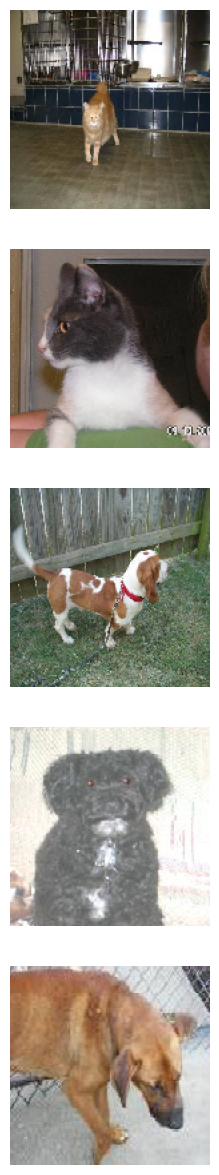

In [4]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


# Melakukan augmentasi data untuk menambah dataset keseluruhan, untuk menghindari overfitting

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(
    rescale=1./255,           # WAJIB (sama seperti sebelumnya)
    rotation_range=15,        # rotasi acak ±15 derajat
    width_shift_range=0.1,    # geser horizontal 10%
    height_shift_range=0.1,   # geser vertikal 10%
    zoom_range=0.1,           # zoom in/out 10%
    brightness_range=(0.8, 1.2), # lebih gelap / terang
    horizontal_flip=True      # flip kiri-kanan
)


# Eksekusi define function augmentasi yang telah dibuat dicell sebelumnya, dan mencoba menampilkan samplingnya

Found 2000 images belonging to 2 classes.


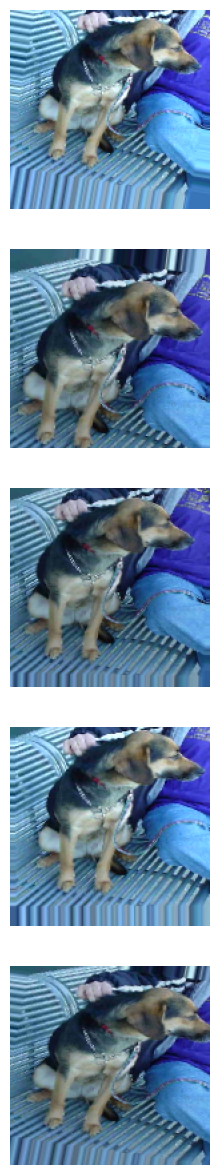

In [6]:
train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,
    batch_size=batch_size,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

# Ambil 1 gambar yang sama, tapi dengan 5 augmentasi berbeda
augmented_images = [
    train_data_gen[0][0][0]
    for _ in range(5)
]

plotImages(augmented_images)


# Buat model CNNnya

In [7]:
model = Sequential([
  Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  MaxPooling2D(2, 2),
  Conv2D(32, (3, 3), activation='relu'),
  MaxPooling2D(2, 2),
  Conv2D(64, (3, 3), activation='relu'),
  MaxPooling2D(2, 2),
  Conv2D(64, (3, 3), activation='relu'),
  MaxPooling2D(2,2),
  Flatten(),
  Dropout(0.5),
  Dense(512, activation='relu'),
  Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,606,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,667,169 (6.36 MB)

 Trainable params: 1,667,169 (6.36 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(x=train_data_gen,
                    steps_per_epoch=8,
                    epochs=epochs,
                    validation_data=val_data_gen,
                    validation_steps=8,
                    verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 48s 6s/step - accuracy: 0.5367 - loss: 0.6896 - val_accuracy: 0.5040 - val_loss: 0.6920
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 48s 6s/step - accuracy: 0.4978 - loss: 0.6978 - val_accuracy: 0.5870 - val_loss: 0.6880
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.5642 - loss: 0.6897 - val_accuracy: 0.5690 - val_loss: 0.6795
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.5897 - loss: 0.6767 - val_accuracy: 0.6030 - val_loss: 0.6638
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 101s 6s/step - accuracy: 0.5935 - loss: 0.6755 - val_accuracy: 0.5140 - val_loss: 0.7314
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.5523 - loss: 0.7063 - val_accuracy: 0.5630 - val_loss: 0.6794
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 99s 6s/step - accuracy: 0.5966 - loss: 0.6707 - val_accuracy: 0.5290 - val_loss: 0.6842
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.5457 - loss: 0.6782 - val_accuracy: 0.6420 - val_loss: 0.6368
Epoch 9

# Menampilkan grafik loss testnya

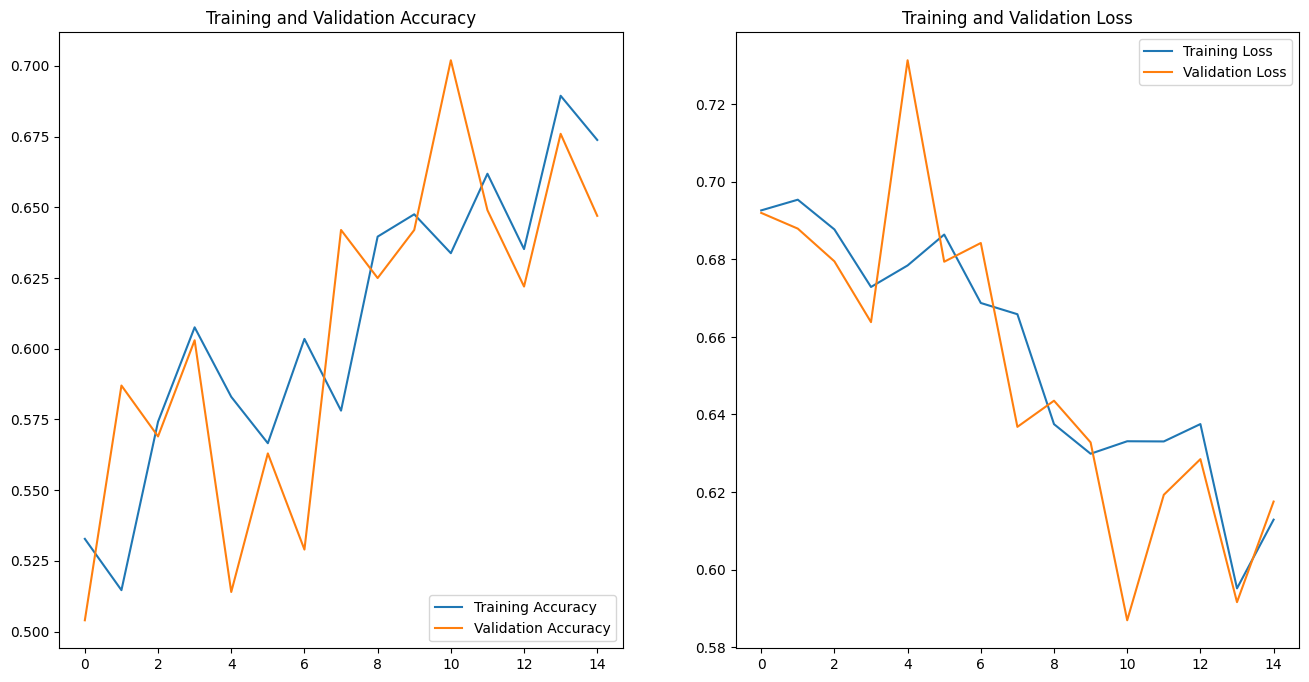

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Prediksi test acak 50 data gambar

In [10]:
array_probabilities = model.predict(test_data_gen)
probabilities = [i[0] for i in array_probabilities]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


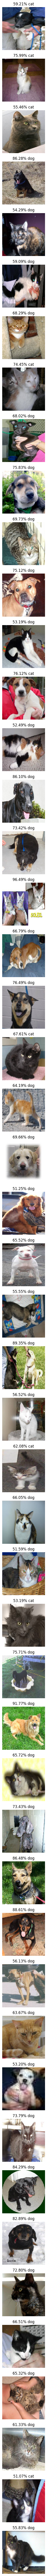

In [11]:
test_images, _ = next(test_data_gen)

plotImages(test_images, probabilities=probabilities)